In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import numpy as np
import pandas as pd
from mvlearn.factorization.ajive import ajive
import matplotlib.pyplot as plt
import seaborn as sns


# Angle-based Joint and Individual Variation Explained

JIVE is a useful algorithm that decomposes multiple views of data into three main categories:
    - Joint Variation
    - Individual Variation
    - Noise
This notebook will prove out the implementation of JIVE and show some examples of the algorithm's usefulness

## Data Creation

Here we create data in the same way detailed in the initial JIVE paper:
<blockquote>
    [1] Lock, Eric F., et al. “Joint and Individual Variation Explained (JIVE) for Integrated Analysis of Multiple Data Types.”        The Annals of Applied Statistics, vol. 7, no. 1, 2013, pp. 523–542., doi:10.1214/12-aoas597.
</blockquote>

The two views are created with a shared joint variation, unique individual variation, and a noise matrix. A representation of what the implementation of this algorithm does can be seen in the cell below.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0047259X1730204X-gr1.jpg">


In [108]:
np.random.seed(12)

# First View
V1_joint = np.bmat([[-1 * np.ones((50, 2000))],
                       [np.ones((50, 2000))]])

V1_joint = np.bmat([np.zeros((100, 8000)), V1_joint])

V1_indiv_t = np.bmat([[np.ones((20, 5000))],
                        [-1 * np.ones((20, 5000))],
                        [np.zeros((20, 5000))],
                        [np.ones((20, 5000))],
                        [-1 * np.ones((20, 5000))]])

V1_indiv_b = np.bmat([[np.ones((25, 5000))],
                        [-1 * np.ones((50, 5000))],
                        [np.ones((25, 5000))]])

V1_indiv_tot = np.bmat([V1_indiv_t, V1_indiv_t])

V1_noise = np.random.normal(loc=0, scale=1, size=(100, 10000))


# Second View
V2_joint = np.bmat([[np.ones((50, 50))],
                      [-1*np.ones((50, 50))]])

V2_joint = 5000 * np.bmat([V2_joint, np.zeros((100, 50))])

V2_indiv = 5000 * np.bmat([[-1 * np.ones((25, 100))],
                              [np.ones((25, 100))],
                              [-1 * np.ones((25, 100))],
                              [np.ones((25, 100))]])

V2_noise = 5000 * np.random.normal(loc=0, scale=1, size=(100, 100))

# View Construction

V1 = V1_indiv_tot + V1_joint + V1_noise

V2 = V2_indiv + V2_joint + V2_noise

Views_1 = [V1, V1]
Views_2 = [V1, V2]

## Scree Plots

Scree plots allow us to observe variation and determine an appropriate initial signal rank for each view

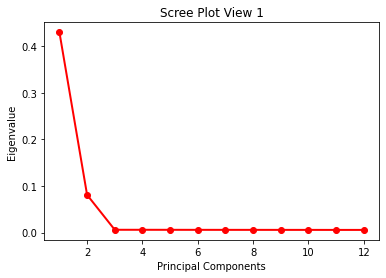

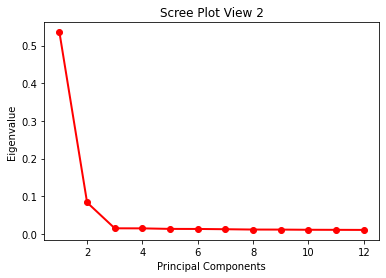

<Figure size 432x288 with 0 Axes>

In [109]:
def scree_plot(n,V,name):
    U, S, V = np.linalg.svd(V)
    eigvals = S**2 / np.sum(S**2)
    eigval_terms = np.arange(n) + 1
    plt.plot(eigval_terms, eigvals[0:n], 'ro-', linewidth=2)
    plt.title('Scree Plot '+ name)
    plt.xlabel('Principal Components')
    plt.ylabel('Eigenvalue')
    plt.figure()

scree_plot(12,V1,'View 1')
scree_plot(12,V2,'View 2')

#It seems as though both inital ranks can be set to 2

In [110]:
#Fitting ajive

ajive1 = ajive(init_signal_ranks= [2,2])
ajive1.fit(Xs=[V1,V1], view_names=['x1','x2'])

ajive2 = ajive(init_signal_ranks= [2,2])
ajive2.fit(Xs=[V1,V2], view_names=['x','y'])



joint rank: 1, block x indiv rank: 1, block y indiv rank: 1

## Output Structure

The get_full_block_estimates() function returns n dictionaries where n is the number of views that fitted. Each dictionary has a joint, individual, and noise matrix taken from the AJIVE decomposition. The keys are 'joint', 'individual', and 'noise' and the values are the respective matrices.


In [111]:
blocks1 = ajive1.predict()
blocks2 = ajive2.predict()


## Heatmap Visualization

Here we are using heatmaps to visualize the decomposition of our views. As we can see when we use two of the same views there is no Individualized Variation displayed. When we create two different views, the algorithm creates different decompositions where common and individual structural artifacts can be seen in their corresponding heatmaps

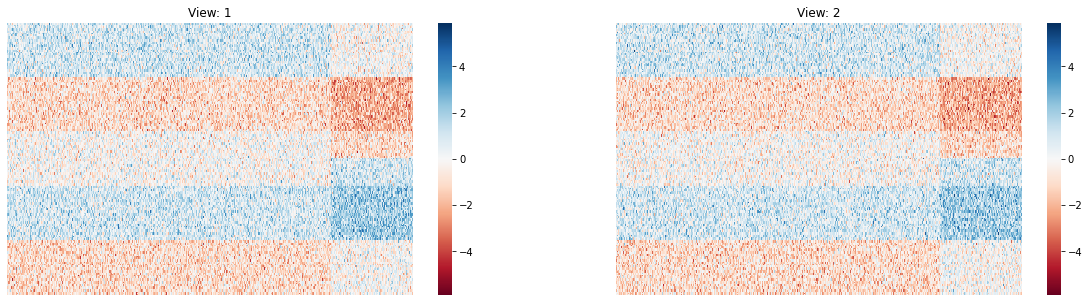

In [112]:
#Same Views
plt.figure(figsize=[20, 5])
ajive.data_block_heatmaps(Views_1)

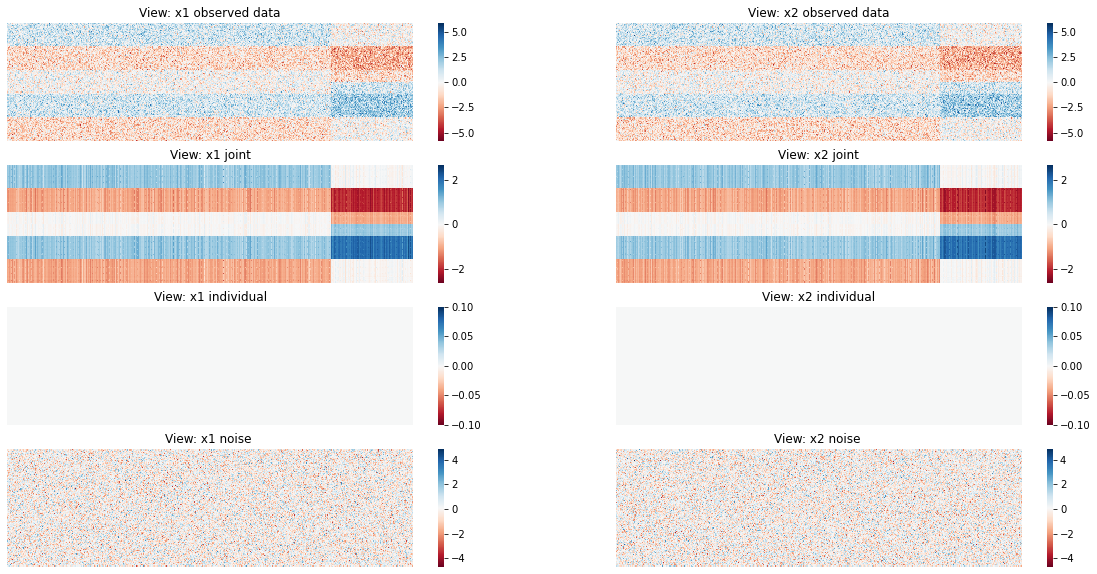

In [113]:
#Same Views
plt.figure(figsize=[20, 10])
plt.title('Same Views')
ajive.ajive_full_estimate_heatmaps(blocks1, Views_1, names=['x1','x2'])

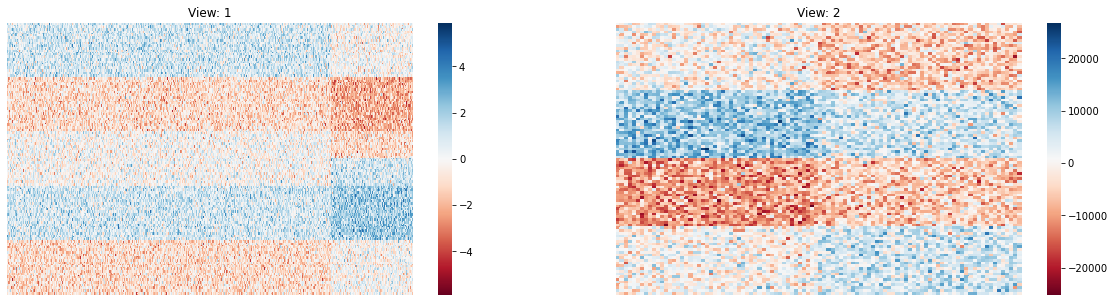

In [114]:
#Different Views
plt.figure(figsize=[20, 5])
ajive.data_block_heatmaps(Views_2)

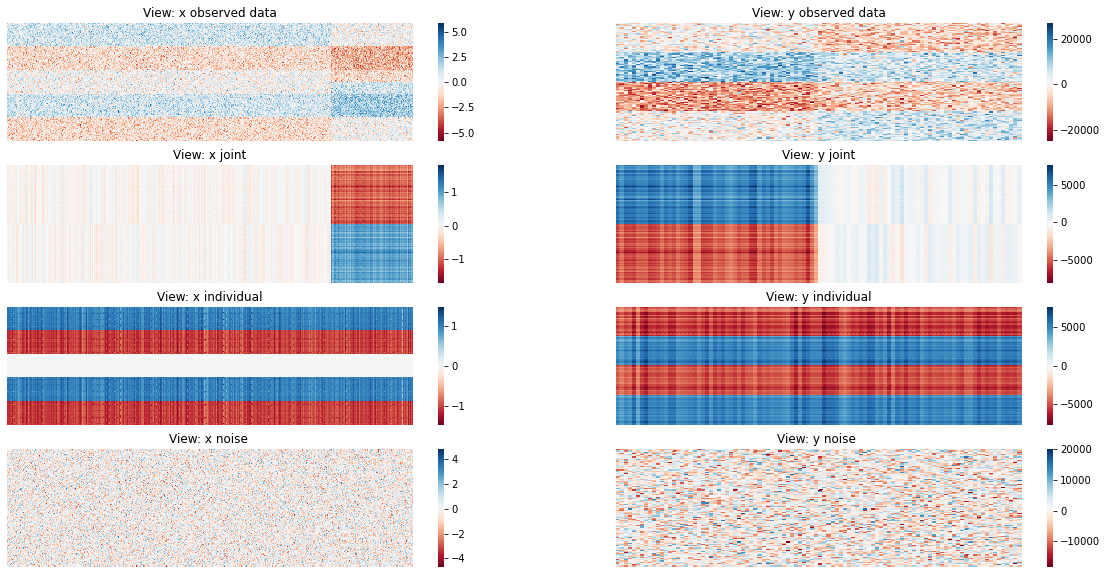

In [115]:
#Different Views

plt.figure(figsize=[20, 10])
ajive.ajive_full_estimate_heatmaps(blocks2, Views_2, names=['x','y'])